In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor



import matplotlib.pyplot as plt 
import seaborn as sn


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error



import scipy.stats as stats
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import sklearn.feature_selection as fs


#evaluation metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error # for regression



# suppress warnings and ignore them
import warnings
warnings.filterwarnings("ignore")

In [3]:
# set the working directory
os.chdir("C:/Users/Pranav/Desktop/Bike Rental Project")

In [4]:
# Read data file
data =pd.read_csv('day.csv')

In [5]:
category_names = ["season","yr","mnth","holiday","weekday","workingday","weathersit"]
numerical_vars = ['temp','atemp', 'hum', 'windspeed']

In [6]:
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# Missing value analysis

In [7]:
data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [ ]:
# there are no missing values

* We are removing "casual" and "registered" because their sum gives us count
* If casual + registered = cnt , then applying machine learning algorithm makes no sense
* We drop dteday as it is redundant. We already have "yr","mnth","workingday","weekday" as attributes

In [8]:
data = data.drop(columns = ["instant","dteday","casual","registered"])

In [9]:
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


# Outlier analysis

We see that there are outliers for "windspeed" and "hum" variables

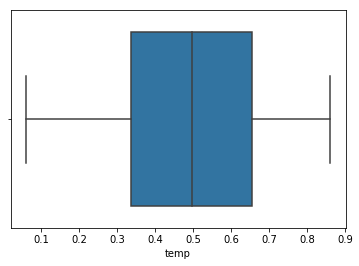

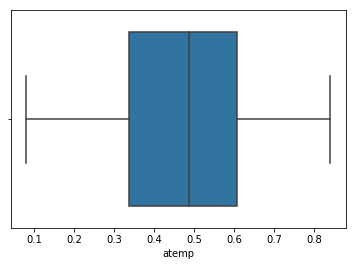

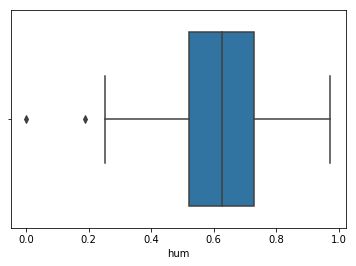

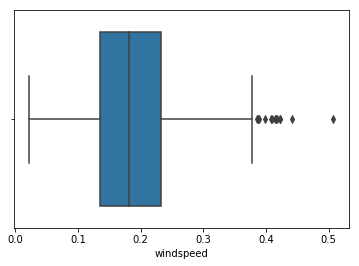

In [10]:
for col in numerical_vars:
    sn.boxplot(data[col])
    plt.show()

In [11]:
# total outliers for each column
Q1 = data[numerical_vars].quantile(0.25)
Q3 = data[numerical_vars].quantile(0.75)
IQR = Q3 - Q1
((data[numerical_vars] < (Q1 - 1.5 * IQR)) | (data[numerical_vars] > (Q3 + 1.5 * IQR))).sum()

temp          0
atemp         0
hum           2
windspeed    13
dtype: int64

Since the data contains fewer records, we don't want to delete the outliers.
Instead we detect the outliers and replace them with mean of the corresponding column

In [12]:
# Detect outliers but now replace them
for i in ["hum","windspeed"]:
    print(i)
    # calculate 75th and 25th percentile
    q75, q25 = np.percentile(data.loc[:,i] , [75,25])
    # calculate inter quartile range
    iqr = q75 - q25
    
    min = q25 - (iqr * 1.5)
    max = q75 + (iqr * 1.5)
    print(min)
    print(max)
    
    data.loc[data[i] < min , i] = np.nan
    data.loc[data[i] > max , i] = np.nan

hum
0.20468725
1.0455212500000002
windspeed
-0.012446750000000034
0.38061125


In [13]:
for i in ["hum","windspeed"]:
    
    data[i] = data[i].fillna(data[i].mean())

# Exploratory data analysis and Feature Selection

In [14]:
# Correlation analysis
# correlation plot
df_corr = data.loc[:,numerical_vars]

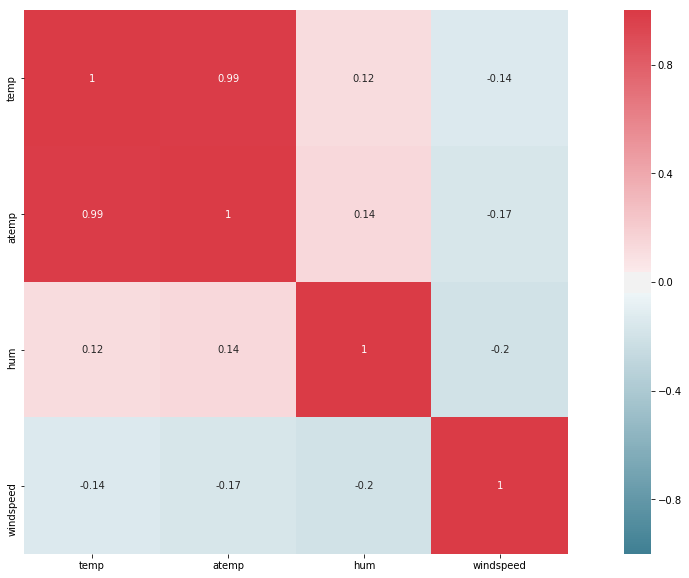

In [15]:
%matplotlib inline
# Set the width and height of the plot
f , ax = plt.subplots(figsize = (20,10))

# Generate correlation matrix
corr = df_corr.corr()

# Plot using seaborn library
sn.heatmap(corr,mask = np.zeros_like(corr,dtype = np.bool), cmap = sn.diverging_palette(220,10,as_cmap = True),
           square = True , ax = ax , vmin = -1 , vmax = 1 , annot = True)

We see that "temp" is highly correlated with "atemp". This can affect our model negatively. Hence we have to remove one of them.

Below we compute the VIF's for the predictors and later remove the one of them having higher VIF

In [16]:
df = data[numerical_vars]

In [17]:
X = add_constant(df)

In [18]:
pd.Series([variance_inflation_factor(X.values,i)
          for i in range(X.shape[1])],
         index = X.columns)

const        45.499530
temp         63.010048
atemp        63.632085
hum           1.059230
windspeed     1.097383
dtype: float64

we clearly see that "atemp" has higher VIF. It will affect our model negatively

In [19]:
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


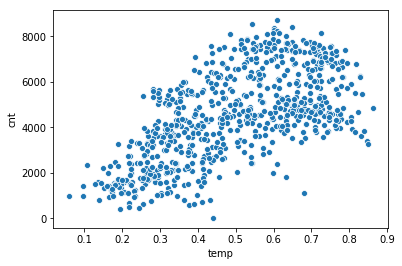

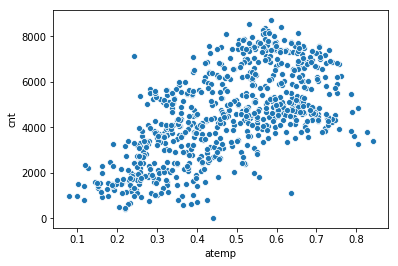

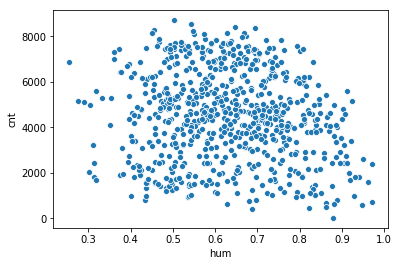

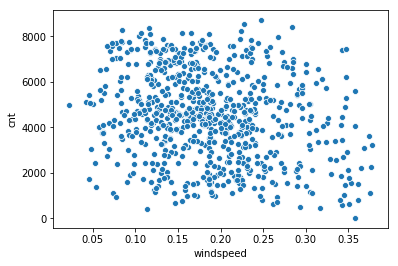

In [20]:
# scatter plots of continuous variables vs cnt
for col in numerical_vars:
    sn.scatterplot(x = col, y = 'cnt' , data = data)
    plt.show()

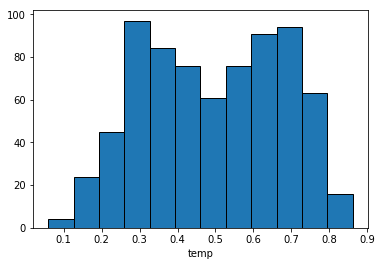

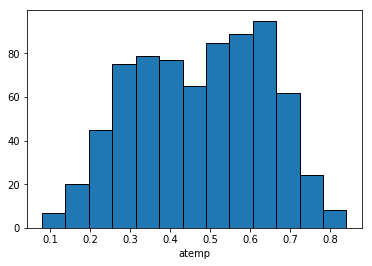

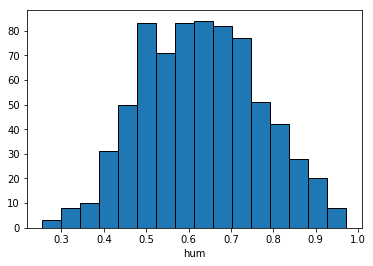

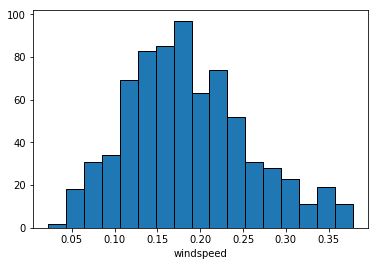

In [21]:
# Plotting histograms of continuous variables

for col in numerical_vars:
    
    plt.hist(data[col],bins = 'auto' ,ec='black')
    plt.xlabel(col)
    plt.show()

Let us visualize the impact of categorical variables over the rental count of the bikes

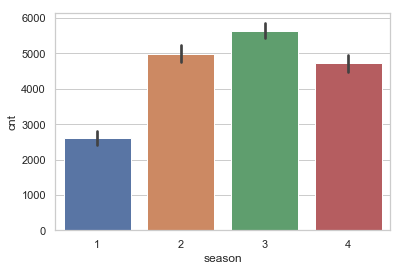

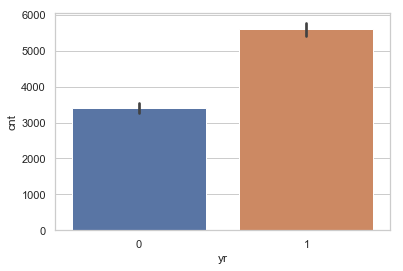

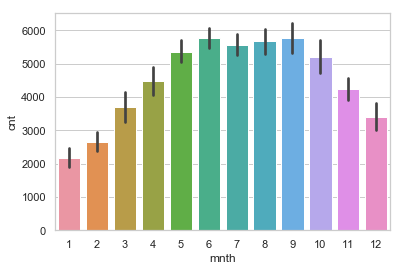

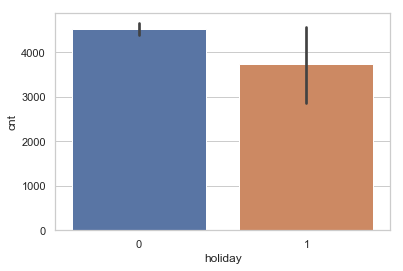

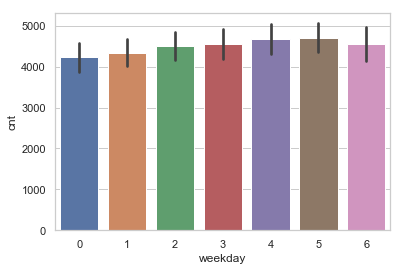

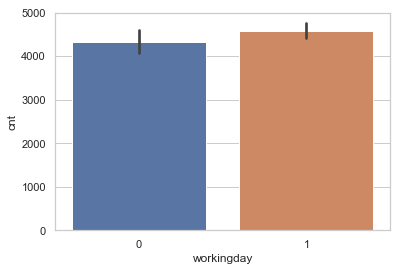

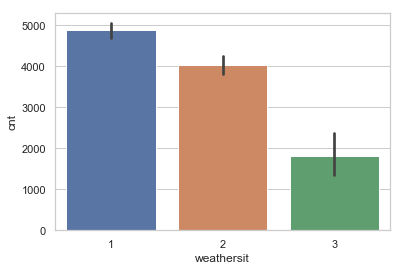

In [22]:
for category in category_names:
    sn.set(style = "whitegrid")
    sn.barplot(x = category, y = 'cnt' , data = data)
    plt.show()

From the barplots above we conclude that
* average bike rental count is maximum during fall and least during spring
* More bikes were rented in 2012 compared to 2011
* More bikes were rented in September. While less number of bikes were rented  during January
* More bikes are rented when there are no holidays
* More bikes are rented on saturdays and less on mondays
* If the day is neither weekend nor holiday more number of bikes are rented
* Clear weather along with few clouds also increases the bike rental count

Below we apply ANOVA to underatnd the relation between categorical variable and the continuous variable cnt

In [23]:
##### Applying ANOVA to understand which categorical variable impact rental count the most
##### F test for selecting categorical variables
##### we will select 7 columns having best F-values

temp_df = data[category_names]

kb = fs.SelectKBest(f_regression,k=7)
kb.fit(temp_df, data['cnt'])
names = temp_df.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores , kb.pvalues_ ))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names','F_Scores', 'P_Vals'])

ns_df_sorted = ns_df.sort_values(['F_Scores','Feat_names'], ascending =[False, True])

ns_df_sorted

,Feat_names,F_Scores,P_Vals
1,yr,344.890586,2.483540e-63
0,season,143.967653,2.133997e-30
6,weathersit,70.729298,2.150976e-16
2,mnth,62.004625,1.243112e-14
3,holiday,3.421441,6.475936e-02
4,weekday,3.331091,6.839081e-02
5,workingday,2.736742,9.849496e-02


F values calculated by ANOVA can be used to interprete the ranking of features based on ability to explain the variance in target variable.

Following is the barplot of F Statics of all the categorical features

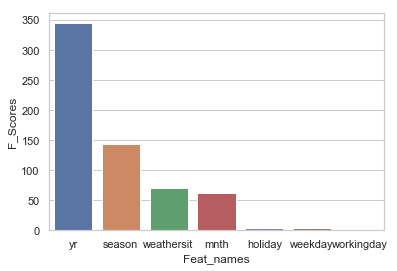

In [24]:
# F-value can be used for feature ranking
# Barplot of f-values for different features
sn.barplot(data = ns_df_sorted , x = "Feat_names", y = "F_Scores")

We are done with the exploratory analysis. We have concluded that "atemp" variable will affect our model negatively. Hence we have to drop it

In [25]:
data = data.drop(columns = ["atemp"])

In [26]:
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,1600


# Model Development

In [27]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data.drop('cnt',axis=1),data['cnt'],test_size=0.25,random_state=2)

In [28]:
# Calculate MAPE
def MAPE(y_true, y_pred):
    mape = np.mean(np.abs((y_true-y_pred)/y_true))
    return mape

## Decision Tree Regressor

In [29]:
dtree_model = DecisionTreeRegressor(random_state=42)
dtree_model.fit(x_train,y_train)
dtree_predictions = dtree_model.predict(x_test)

In [30]:
print("MAE for decision tree regressor is ",mean_absolute_error(y_test,dtree_predictions))
print("MAPE for decision tree regressor is ",MAPE(y_test,dtree_predictions))
print("MSE for decision tree regressor is ",mean_squared_error(y_test,dtree_predictions))
print("RMSE for decision tree regressor is ",np.sqrt(mean_squared_error(y_test,dtree_predictions)))

MAE for decision tree regressor is  624.6448087431694
MAPE for decision tree regressor is  0.18283266755725586
MSE for decision tree regressor is  699043.8032786886
RMSE for decision tree regressor is  836.0883944169352


##### Decision Tree hyperparameter tuning

In [31]:
kf = KFold(n_splits= 3 , random_state=42)
params_dict = {
              'min_samples_leaf': list(range(1,20,2)),
              'max_features': list(range(1,11))
              }

dtree_tune=GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                        param_grid=params_dict ,
                        cv = kf,
                        scoring='neg_mean_absolute_error',
                        verbose=6000)
dtree_tune.fit(x_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_features=1, min_samples_leaf=1 ..............................
[CV]  max_features=1, min_samples_leaf=1, score=-1055.372, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] max_features=1, min_samples_leaf=1 ..............................
[CV]  max_features=1, min_samples_leaf=1, score=-1198.678, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] max_features=1, min_samples_leaf=1 ..............................
[CV]  max_features=1, min_samples_leaf=1, score=-1104.978, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] max_features=1, min_samples_leaf=3 ..............................
[CV]  max_features=1, min_samples_leaf=3, score=-1140.391, total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   

[CV]  max_features=2, min_samples_leaf=5, score=-1061.588, total=   0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    0.1s remaining:    0.0s
[CV] max_features=2, min_samples_leaf=7 ..............................
[CV]  max_features=2, min_samples_leaf=7, score=-694.956, total=   0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s remaining:    0.0s
[CV] max_features=2, min_samples_leaf=7 ..............................
[CV]  max_features=2, min_samples_leaf=7, score=-885.634, total=   0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    0.1s remaining:    0.0s
[CV] max_features=2, min_samples_leaf=7 ..............................
[CV]  max_features=2, min_samples_leaf=7, score=-862.746, total=   0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    0.1s remaining:    0.0s
[CV] max_features=2, min_samples_leaf=9 ..............................
[CV]  max_features=2, min_samples_leaf=9, score=-998.819, total=   0.0s
[Parallel(n_jobs=1)]: Done  43 out 

[CV] max_features=3, min_samples_leaf=13 .............................
[CV]  max_features=3, min_samples_leaf=13, score=-921.454, total=   0.0s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    0.3s remaining:    0.0s
[CV] max_features=3, min_samples_leaf=15 .............................
[CV]  max_features=3, min_samples_leaf=15, score=-910.321, total=   0.0s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:    0.3s remaining:    0.0s
[CV] max_features=3, min_samples_leaf=15 .............................
[CV]  max_features=3, min_samples_leaf=15, score=-898.913, total=   0.0s
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:    0.3s remaining:    0.0s
[CV] max_features=3, min_samples_leaf=15 .............................
[CV]  max_features=3, min_samples_leaf=15, score=-922.340, total=   0.0s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.3s remaining:    0.0s
[CV] max_features=3, min_samples_leaf=17 .............................
[CV]  max_features=3, min_samples

[Parallel(n_jobs=1)]: Done 121 out of 121 | elapsed:    0.5s remaining:    0.0s
[CV] max_features=5, min_samples_leaf=1 ..............................
[CV]  max_features=5, min_samples_leaf=1, score=-666.339, total=   0.0s
[Parallel(n_jobs=1)]: Done 122 out of 122 | elapsed:    0.5s remaining:    0.0s
[CV] max_features=5, min_samples_leaf=1 ..............................
[CV]  max_features=5, min_samples_leaf=1, score=-867.555, total=   0.0s
[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed:    0.5s remaining:    0.0s
[CV] max_features=5, min_samples_leaf=3 ..............................
[CV]  max_features=5, min_samples_leaf=3, score=-697.359, total=   0.0s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:    0.5s remaining:    0.0s
[CV] max_features=5, min_samples_leaf=3 ..............................
[CV]  max_features=5, min_samples_leaf=3, score=-683.192, total=   0.0s
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.5s remaining:    0.0s
[CV] max_features=5, min_sam

[CV]  max_features=6, min_samples_leaf=7, score=-875.262, total=   0.0s
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:    0.7s remaining:    0.0s
[CV] max_features=6, min_samples_leaf=9 ..............................
[CV]  max_features=6, min_samples_leaf=9, score=-667.378, total=   0.0s
[Parallel(n_jobs=1)]: Done 163 out of 163 | elapsed:    0.7s remaining:    0.0s
[CV] max_features=6, min_samples_leaf=9 ..............................
[CV]  max_features=6, min_samples_leaf=9, score=-756.464, total=   0.0s
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.7s remaining:    0.0s
[CV] max_features=6, min_samples_leaf=9 ..............................
[CV]  max_features=6, min_samples_leaf=9, score=-784.713, total=   0.0s
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:    0.7s remaining:    0.0s
[CV] max_features=6, min_samples_leaf=11 .............................
[CV]  max_features=6, min_samples_leaf=11, score=-679.965, total=   0.0s
[Parallel(n_jobs=1)]: Done 166 out 

[CV]  max_features=7, min_samples_leaf=17, score=-724.202, total=   0.0s
[Parallel(n_jobs=1)]: Done 206 out of 206 | elapsed:    0.9s remaining:    0.0s
[CV] max_features=7, min_samples_leaf=17 .............................
[CV]  max_features=7, min_samples_leaf=17, score=-718.268, total=   0.0s
[Parallel(n_jobs=1)]: Done 207 out of 207 | elapsed:    0.9s remaining:    0.0s
[CV] max_features=7, min_samples_leaf=19 .............................
[CV]  max_features=7, min_samples_leaf=19, score=-660.938, total=   0.0s
[Parallel(n_jobs=1)]: Done 208 out of 208 | elapsed:    1.0s remaining:    0.0s
[CV] max_features=7, min_samples_leaf=19 .............................
[CV]  max_features=7, min_samples_leaf=19, score=-759.023, total=   0.0s
[Parallel(n_jobs=1)]: Done 209 out of 209 | elapsed:    1.0s remaining:    0.0s
[CV] max_features=7, min_samples_leaf=19 .............................
[CV]  max_features=7, min_samples_leaf=19, score=-738.043, total=   0.0s
[Parallel(n_jobs=1)]: Done 210 

[CV]  max_features=9, min_samples_leaf=3, score=-681.619, total=   0.0s
[Parallel(n_jobs=1)]: Done 246 out of 246 | elapsed:    1.1s remaining:    0.0s
[CV] max_features=9, min_samples_leaf=5 ..............................
[CV]  max_features=9, min_samples_leaf=5, score=-645.792, total=   0.0s
[Parallel(n_jobs=1)]: Done 247 out of 247 | elapsed:    1.2s remaining:    0.0s
[CV] max_features=9, min_samples_leaf=5 ..............................
[CV]  max_features=9, min_samples_leaf=5, score=-627.821, total=   0.0s
[Parallel(n_jobs=1)]: Done 248 out of 248 | elapsed:    1.2s remaining:    0.0s
[CV] max_features=9, min_samples_leaf=5 ..............................
[CV]  max_features=9, min_samples_leaf=5, score=-674.448, total=   0.0s
[Parallel(n_jobs=1)]: Done 249 out of 249 | elapsed:    1.2s remaining:    0.0s
[CV] max_features=9, min_samples_leaf=7 ..............................
[CV]  max_features=9, min_samples_leaf=7, score=-629.432, total=   0.0s
[Parallel(n_jobs=1)]: Done 250 out o

[CV]  max_features=10, min_samples_leaf=9, score=-700.323, total=   0.0s
[Parallel(n_jobs=1)]: Done 285 out of 285 | elapsed:    1.4s remaining:    0.0s
[CV] max_features=10, min_samples_leaf=11 ............................
[CV]  max_features=10, min_samples_leaf=11, score=-621.307, total=   0.0s
[Parallel(n_jobs=1)]: Done 286 out of 286 | elapsed:    1.4s remaining:    0.0s
[CV] max_features=10, min_samples_leaf=11 ............................
[CV]  max_features=10, min_samples_leaf=11, score=-668.948, total=   0.0s
[Parallel(n_jobs=1)]: Done 287 out of 287 | elapsed:    1.4s remaining:    0.0s
[CV] max_features=10, min_samples_leaf=11 ............................
[CV]  max_features=10, min_samples_leaf=11, score=-714.041, total=   0.0s
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:    1.4s remaining:    0.0s
[CV] max_features=10, min_samples_leaf=13 ............................
[CV]  max_features=10, min_samples_leaf=13, score=-648.362, total=   0.0s
[Parallel(n_jobs=1)]: Done 

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=42,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13, 15, 17,
  

In [32]:
dtree_tune.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=10,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [33]:
dtree_tuned_predictions=dtree_tune.predict(x_test)

print("MAE after decision tree after hyperparameter tuning is ",mean_absolute_error(y_test,dtree_tuned_predictions))
print("MAPE after decision tree after hyperparameter tuning is ",MAPE(y_test,dtree_tuned_predictions))
print("MSE after decision tree after hyperparameter tuning is ",mean_squared_error(y_test,dtree_tuned_predictions))
print("RMSE after decision tree after hyperparameter tuning is ",
      np.sqrt(mean_squared_error(y_test,dtree_tuned_predictions)))

MAE after decision tree after hyperparameter tuning is  583.1435467083008
MAPE after decision tree after hyperparameter tuning is  0.17279279436900477
MSE after decision tree after hyperparameter tuning is  640628.326230909
RMSE after decision tree after hyperparameter tuning is  800.3926075563847


## Random Forest Regressor

In [34]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(x_train,y_train)
rf_predictions = rf_model.predict(x_test)

In [35]:
print("MAE for random forest regressor is ",mean_absolute_error(y_test,rf_predictions))
print("MAPE for random forest regressor is ",MAPE(y_test,rf_predictions))
print("MSE for random forest regressor is ",mean_squared_error(y_test,rf_predictions))
print("RMSE for random forest regressor is ",np.sqrt(mean_squared_error(y_test,rf_predictions)))

MAE for random forest regressor is  509.5945355191257
MAPE for random forest regressor is  0.1591791117864434
MSE for random forest regressor is  488724.9433879781
RMSE for random forest regressor is  699.0886520234599


#### Random Forest hyperparameter tuning

In [36]:
#for random forest regresion.

kf = KFold(n_splits= 3 , random_state=42)

param_grid={'n_estimators':[100,200,300,400,500],'max_features':list(range(1,11)),'max_depth': [4,6,8]}

rf_tune=GridSearchCV(RandomForestRegressor(random_state=42),
                     param_grid=param_grid ,
                     cv=kf ,
                     scoring = 'neg_mean_absolute_error',
                     verbose= 6000)

rf_tune.fit(x_train,y_train)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=4, max_features=1, n_estimators=100 ...................
[CV]  max_depth=4, max_features=1, n_estimators=100, score=-856.389, total=   0.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=4, max_features=1, n_estimators=100 ...................
[CV]  max_depth=4, max_features=1, n_estimators=100, score=-943.430, total=   0.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=4, max_features=1, n_estimators=100 ...................
[CV]  max_depth=4, max_features=1, n_estimators=100, score=-1048.545, total=   0.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=4, max_features=1, n_estimators=200 ...................
[CV]  max_depth=4, max_features=1, n_estimators=200, score=-867.813, total=   0.2s

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   11.3s remaining:    0.0s
[CV] max_depth=4, max_features=3, n_estimators=300 ...................
[CV]  max_depth=4, max_features=3, n_estimators=300, score=-593.055, total=   0.4s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   11.7s remaining:    0.0s
[CV] max_depth=4, max_features=3, n_estimators=300 ...................
[CV]  max_depth=4, max_features=3, n_estimators=300, score=-692.667, total=   0.3s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   12.1s remaining:    0.0s
[CV] max_depth=4, max_features=3, n_estimators=300 ...................
[CV]  max_depth=4, max_features=3, n_estimators=300, score=-737.845, total=   0.3s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   12.4s remaining:    0.0s
[CV] max_depth=4, max_features=3, n_estimators=400 ...................
[CV]  max_depth=4, max_features=3, n_estimators=400, score=-592.236, total=   0.5s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   12.9s rem

[CV]  max_depth=4, max_features=5, n_estimators=400, score=-642.954, total=   0.5s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   25.0s remaining:    0.0s
[CV] max_depth=4, max_features=5, n_estimators=500 ...................
[CV]  max_depth=4, max_features=5, n_estimators=500, score=-542.831, total=   0.6s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   25.6s remaining:    0.0s
[CV] max_depth=4, max_features=5, n_estimators=500 ...................
[CV]  max_depth=4, max_features=5, n_estimators=500, score=-614.206, total=   0.6s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   26.2s remaining:    0.0s
[CV] max_depth=4, max_features=5, n_estimators=500 ...................
[CV]  max_depth=4, max_features=5, n_estimators=500, score=-643.402, total=   0.7s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   26.9s remaining:    0.0s
[CV] max_depth=4, max_features=6, n_estimators=100 ...................
[CV]  max_depth=4, max_features=6, n_estimators=100, score=-546.

[CV]  max_depth=4, max_features=8, n_estimators=200, score=-565.996, total=   0.2s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:   38.7s remaining:    0.0s
[CV] max_depth=4, max_features=8, n_estimators=200 ...................
[CV]  max_depth=4, max_features=8, n_estimators=200, score=-601.734, total=   0.2s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:   38.9s remaining:    0.0s
[CV] max_depth=4, max_features=8, n_estimators=200 ...................
[CV]  max_depth=4, max_features=8, n_estimators=200, score=-606.540, total=   0.3s
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:   39.2s remaining:    0.0s
[CV] max_depth=4, max_features=8, n_estimators=300 ...................
[CV]  max_depth=4, max_features=8, n_estimators=300, score=-564.568, total=   0.4s
[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:   39.5s remaining:    0.0s
[CV] max_depth=4, max_features=8, n_estimators=300 ...................
[CV]  max_depth=4, max_features=8, n_estimators=300, score=-602.

[CV]  max_depth=4, max_features=10, n_estimators=300, score=-616.014, total=   0.4s
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:   51.3s remaining:    0.0s
[CV] max_depth=4, max_features=10, n_estimators=400 ..................
[CV]  max_depth=4, max_features=10, n_estimators=400, score=-581.284, total=   0.5s
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:   51.8s remaining:    0.0s
[CV] max_depth=4, max_features=10, n_estimators=400 ..................
[CV]  max_depth=4, max_features=10, n_estimators=400, score=-606.527, total=   0.5s
[Parallel(n_jobs=1)]: Done 146 out of 146 | elapsed:   52.2s remaining:    0.0s
[CV] max_depth=4, max_features=10, n_estimators=400 ..................
[CV]  max_depth=4, max_features=10, n_estimators=400, score=-618.263, total=   0.5s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:   52.7s remaining:    0.0s
[CV] max_depth=4, max_features=10, n_estimators=500 ..................
[CV]  max_depth=4, max_features=10, n_estimators=500, score=

[CV]  max_depth=6, max_features=2, n_estimators=500, score=-650.703, total=   0.6s
[Parallel(n_jobs=1)]: Done 179 out of 179 | elapsed:  1.1min remaining:    0.0s
[CV] max_depth=6, max_features=2, n_estimators=500 ...................
[CV]  max_depth=6, max_features=2, n_estimators=500, score=-699.015, total=   0.6s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.1min remaining:    0.0s
[CV] max_depth=6, max_features=3, n_estimators=100 ...................
[CV]  max_depth=6, max_features=3, n_estimators=100, score=-514.942, total=   0.1s
[Parallel(n_jobs=1)]: Done 181 out of 181 | elapsed:  1.1min remaining:    0.0s
[CV] max_depth=6, max_features=3, n_estimators=100 ...................
[CV]  max_depth=6, max_features=3, n_estimators=100, score=-589.043, total=   0.1s
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:  1.1min remaining:    0.0s
[CV] max_depth=6, max_features=3, n_estimators=100 ...................
[CV]  max_depth=6, max_features=3, n_estimators=100, score=-612.

[CV]  max_depth=6, max_features=5, n_estimators=200, score=-535.878, total=   0.2s
[Parallel(n_jobs=1)]: Done 215 out of 215 | elapsed:  1.3min remaining:    0.0s
[CV] max_depth=6, max_features=5, n_estimators=200 ...................
[CV]  max_depth=6, max_features=5, n_estimators=200, score=-546.143, total=   0.2s
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:  1.3min remaining:    0.0s
[CV] max_depth=6, max_features=5, n_estimators=300 ...................
[CV]  max_depth=6, max_features=5, n_estimators=300, score=-499.080, total=   0.4s
[Parallel(n_jobs=1)]: Done 217 out of 217 | elapsed:  1.3min remaining:    0.0s
[CV] max_depth=6, max_features=5, n_estimators=300 ...................
[CV]  max_depth=6, max_features=5, n_estimators=300, score=-540.616, total=   0.4s
[Parallel(n_jobs=1)]: Done 218 out of 218 | elapsed:  1.3min remaining:    0.0s
[CV] max_depth=6, max_features=5, n_estimators=300 ...................
[CV]  max_depth=6, max_features=5, n_estimators=300, score=-552.

[CV]  max_depth=6, max_features=7, n_estimators=400, score=-537.883, total=   0.5s
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=6, max_features=7, n_estimators=400 ...................
[CV]  max_depth=6, max_features=7, n_estimators=400, score=-542.719, total=   0.5s
[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=6, max_features=7, n_estimators=500 ...................
[CV]  max_depth=6, max_features=7, n_estimators=500, score=-504.394, total=   0.6s
[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=6, max_features=7, n_estimators=500 ...................
[CV]  max_depth=6, max_features=7, n_estimators=500, score=-536.184, total=   0.6s
[Parallel(n_jobs=1)]: Done 254 out of 254 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=6, max_features=7, n_estimators=500 ...................
[CV]  max_depth=6, max_features=7, n_estimators=500, score=-542.

[CV]  max_depth=6, max_features=10, n_estimators=100, score=-541.931, total=   0.1s
[Parallel(n_jobs=1)]: Done 287 out of 287 | elapsed:  1.8min remaining:    0.0s
[CV] max_depth=6, max_features=10, n_estimators=100 ..................
[CV]  max_depth=6, max_features=10, n_estimators=100, score=-553.761, total=   0.1s
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  1.8min remaining:    0.0s
[CV] max_depth=6, max_features=10, n_estimators=200 ..................
[CV]  max_depth=6, max_features=10, n_estimators=200, score=-522.132, total=   0.3s
[Parallel(n_jobs=1)]: Done 289 out of 289 | elapsed:  1.8min remaining:    0.0s
[CV] max_depth=6, max_features=10, n_estimators=200 ..................
[CV]  max_depth=6, max_features=10, n_estimators=200, score=-540.621, total=   0.3s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:  1.8min remaining:    0.0s
[CV] max_depth=6, max_features=10, n_estimators=200 ..................
[CV]  max_depth=6, max_features=10, n_estimators=200, score=

[CV]  max_depth=8, max_features=2, n_estimators=300, score=-531.464, total=   0.4s
[Parallel(n_jobs=1)]: Done 322 out of 322 | elapsed:  2.0min remaining:    0.0s
[CV] max_depth=8, max_features=2, n_estimators=300 ...................
[CV]  max_depth=8, max_features=2, n_estimators=300, score=-589.796, total=   0.4s
[Parallel(n_jobs=1)]: Done 323 out of 323 | elapsed:  2.0min remaining:    0.0s
[CV] max_depth=8, max_features=2, n_estimators=300 ...................
[CV]  max_depth=8, max_features=2, n_estimators=300, score=-635.025, total=   0.4s
[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:  2.0min remaining:    0.0s
[CV] max_depth=8, max_features=2, n_estimators=400 ...................
[CV]  max_depth=8, max_features=2, n_estimators=400, score=-530.045, total=   0.5s
[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:  2.0min remaining:    0.0s
[CV] max_depth=8, max_features=2, n_estimators=400 ...................
[CV]  max_depth=8, max_features=2, n_estimators=400, score=-592.

[CV]  max_depth=8, max_features=4, n_estimators=500, score=-479.949, total=   0.6s
[Parallel(n_jobs=1)]: Done 358 out of 358 | elapsed:  2.2min remaining:    0.0s
[CV] max_depth=8, max_features=4, n_estimators=500 ...................
[CV]  max_depth=8, max_features=4, n_estimators=500, score=-521.421, total=   0.6s
[Parallel(n_jobs=1)]: Done 359 out of 359 | elapsed:  2.2min remaining:    0.0s
[CV] max_depth=8, max_features=4, n_estimators=500 ...................
[CV]  max_depth=8, max_features=4, n_estimators=500, score=-523.944, total=   0.7s
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  2.2min remaining:    0.0s
[CV] max_depth=8, max_features=5, n_estimators=100 ...................
[CV]  max_depth=8, max_features=5, n_estimators=100, score=-494.092, total=   0.1s
[Parallel(n_jobs=1)]: Done 361 out of 361 | elapsed:  2.2min remaining:    0.0s
[CV] max_depth=8, max_features=5, n_estimators=100 ...................
[CV]  max_depth=8, max_features=5, n_estimators=100, score=-528.

[CV]  max_depth=8, max_features=7, n_estimators=200, score=-498.116, total=   0.3s
[Parallel(n_jobs=1)]: Done 394 out of 394 | elapsed:  2.4min remaining:    0.0s
[CV] max_depth=8, max_features=7, n_estimators=200 ...................
[CV]  max_depth=8, max_features=7, n_estimators=200, score=-512.602, total=   0.3s
[Parallel(n_jobs=1)]: Done 395 out of 395 | elapsed:  2.5min remaining:    0.0s
[CV] max_depth=8, max_features=7, n_estimators=200 ...................
[CV]  max_depth=8, max_features=7, n_estimators=200, score=-516.880, total=   0.3s
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:  2.5min remaining:    0.0s
[CV] max_depth=8, max_features=7, n_estimators=300 ...................
[CV]  max_depth=8, max_features=7, n_estimators=300, score=-496.621, total=   0.5s
[Parallel(n_jobs=1)]: Done 397 out of 397 | elapsed:  2.5min remaining:    0.0s
[CV] max_depth=8, max_features=7, n_estimators=300 ...................
[CV]  max_depth=8, max_features=7, n_estimators=300, score=-511.

[CV]  max_depth=8, max_features=9, n_estimators=400, score=-503.668, total=   0.6s
[Parallel(n_jobs=1)]: Done 430 out of 430 | elapsed:  2.7min remaining:    0.0s
[CV] max_depth=8, max_features=9, n_estimators=400 ...................
[CV]  max_depth=8, max_features=9, n_estimators=400, score=-520.521, total=   0.6s
[Parallel(n_jobs=1)]: Done 431 out of 431 | elapsed:  2.7min remaining:    0.0s
[CV] max_depth=8, max_features=9, n_estimators=400 ...................
[CV]  max_depth=8, max_features=9, n_estimators=400, score=-526.653, total=   0.6s
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:  2.8min remaining:    0.0s
[CV] max_depth=8, max_features=9, n_estimators=500 ...................
[CV]  max_depth=8, max_features=9, n_estimators=500, score=-502.293, total=   0.7s
[Parallel(n_jobs=1)]: Done 433 out of 433 | elapsed:  2.8min remaining:    0.0s
[CV] max_depth=8, max_features=9, n_estimators=500 ...................
[CV]  max_depth=8, max_features=9, n_estimators=500, score=-519.

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=Non

In [37]:
rf_tune.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [38]:
rf_tuned_predictions=rf_tune.predict(x_test)

print("MAPE after random forest hyperparameter tuning is ",MAPE(y_test,rf_tuned_predictions))
print("MAE after random forest hyperparameter tuning is ",mean_absolute_error(y_test,rf_tuned_predictions))
print("MSE after random forest hyperparameter tuning is ",mean_squared_error(y_test,rf_tuned_predictions))
print("RMSE after random forest hyperparameter tuning is ",np.sqrt(mean_squared_error(y_test,rf_tuned_predictions)))

MAPE after random forest hyperparameter tuning is  0.14447484271238206
MAE after random forest hyperparameter tuning is  474.4333269936359
MSE after random forest hyperparameter tuning is  422038.1917541686
RMSE after random forest hyperparameter tuning is  649.6446657628835


## Gradient Boost Regression

In [39]:
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(x_train,y_train)
gbr_predictions = gbr_model.predict(x_test)

In [40]:
print("MAE for gradient boosting regressor is ",mean_absolute_error(y_test,gbr_predictions))
print("MAPE for gradient boosting regressor is ",MAPE(y_test,gbr_predictions))
print("MSE for gradient boosting regressor is ",mean_squared_error(y_test,gbr_predictions))
print("RMSE for gradient boosting regressor is ",np.sqrt(mean_squared_error(y_test,gbr_predictions)))

MAE for gradient boosting regressor is  495.4848806408682
MAPE for gradient boosting regressor is  0.14976151863699272
MSE for gradient boosting regressor is  433500.6448948831
RMSE for gradient boosting regressor is  658.407658593734


#### Gradient Boost Hyperparameter tuning. 

In [41]:
# gradient boost hyper parameter tuning

kf = KFold(n_splits= 3 , random_state=42)

gb_grid_params = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6, 8],
              'min_samples_leaf': [20,30,40],
              'n_estimators' : [1000,2000,3000,4000,5000]
              }

gbr_tuned = GridSearchCV(GradientBoostingRegressor(random_state=42),
                   gb_grid_params,
                   cv=kf,
                   scoring = "neg_mean_absolute_error",
                   verbose = 6000)

gbr_tuned.fit(x_train,y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=1000 
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=1000, score=-522.382, total=   0.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=1000 
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=1000, score=-531.086, total=   0.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=1000 
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=1000, score=-539.502, total=   0.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_e

[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=40, n_estimators=1000, score=-543.561, total=   0.3s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   30.9s remaining:    0.0s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=40, n_estimators=1000 
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=40, n_estimators=1000, score=-551.020, total=   0.3s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   31.2s remaining:    0.0s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=40, n_estimators=2000 
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=40, n_estimators=2000, score=-530.806, total=   0.6s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   31.8s remaining:    0.0s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=40, n_estimators=2000 
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=40, n_estimators=2000, score=-544.494, total=   0.8s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   32.6s remaining:    0.0s
[CV] learning_rat

[CV]  learning_rate=0.1, max_depth=6, min_samples_leaf=30, n_estimators=1000, score=-533.854, total=   0.4s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:  1.1min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=30, n_estimators=2000 
[CV]  learning_rate=0.1, max_depth=6, min_samples_leaf=30, n_estimators=2000, score=-509.665, total=   0.7s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:  1.1min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=30, n_estimators=2000 
[CV]  learning_rate=0.1, max_depth=6, min_samples_leaf=30, n_estimators=2000, score=-545.716, total=   0.7s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  1.1min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=30, n_estimators=2000 
[CV]  learning_rate=0.1, max_depth=6, min_samples_leaf=30, n_estimators=2000, score=-541.027, total=   0.9s
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:  1.2min remaining:    0.0s
[CV] learning_rat

[CV]  learning_rate=0.1, max_depth=8, min_samples_leaf=20, n_estimators=2000, score=-502.362, total=   1.0s
[Parallel(n_jobs=1)]: Done  94 out of  94 | elapsed:  1.8min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=8, min_samples_leaf=20, n_estimators=2000 
[CV]  learning_rate=0.1, max_depth=8, min_samples_leaf=20, n_estimators=2000, score=-537.994, total=   0.9s
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:  1.8min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=8, min_samples_leaf=20, n_estimators=2000 
[CV]  learning_rate=0.1, max_depth=8, min_samples_leaf=20, n_estimators=2000, score=-539.098, total=   1.2s
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  1.8min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=8, min_samples_leaf=20, n_estimators=3000 
[CV]  learning_rate=0.1, max_depth=8, min_samples_leaf=20, n_estimators=3000, score=-502.460, total=   1.8s
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:  1.8min remaining:    0.0s
[CV] learning_rat

[CV]  learning_rate=0.1, max_depth=8, min_samples_leaf=40, n_estimators=2000, score=-542.587, total=   0.7s
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.5min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=8, min_samples_leaf=40, n_estimators=2000 
[CV]  learning_rate=0.1, max_depth=8, min_samples_leaf=40, n_estimators=2000, score=-580.067, total=   0.7s
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:  2.5min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=8, min_samples_leaf=40, n_estimators=3000 
[CV]  learning_rate=0.1, max_depth=8, min_samples_leaf=40, n_estimators=3000, score=-532.112, total=   1.0s
[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:  2.5min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=8, min_samples_leaf=40, n_estimators=3000 
[CV]  learning_rate=0.1, max_depth=8, min_samples_leaf=40, n_estimators=3000, score=-546.795, total=   1.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:  2.5min remaining:    0.0s
[CV] learning_rat

[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=30, n_estimators=2000, score=-523.454, total=   0.7s
[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=30, n_estimators=3000 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=30, n_estimators=3000, score=-505.469, total=   1.0s
[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=30, n_estimators=3000 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=30, n_estimators=3000, score=-540.940, total=   1.2s
[Parallel(n_jobs=1)]: Done 158 out of 158 | elapsed:  3.1min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=30, n_estimators=3000 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=30, n_estimators=3000, score=-531.503, total=   1.3s
[Parallel(n_jobs=1)]: Done 159 out of 159 | elapsed:  3.1min remaining:    0.0s
[CV] learn

[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=20, n_estimators=3000, score=-501.875, total=   1.5s
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:  3.6min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=20, n_estimators=3000 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=20, n_estimators=3000, score=-531.368, total=   1.4s
[Parallel(n_jobs=1)]: Done 188 out of 188 | elapsed:  3.6min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=20, n_estimators=3000 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=20, n_estimators=3000, score=-554.934, total=   1.3s
[Parallel(n_jobs=1)]: Done 189 out of 189 | elapsed:  3.6min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=20, n_estimators=4000 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=20, n_estimators=4000, score=-502.648, total=   1.6s
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:  3.7min remaining:    0.0s
[CV] learn

[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=40, n_estimators=3000, score=-548.401, total=   1.2s
[Parallel(n_jobs=1)]: Done 218 out of 218 | elapsed:  4.2min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=40, n_estimators=3000 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=40, n_estimators=3000, score=-575.557, total=   1.0s
[Parallel(n_jobs=1)]: Done 219 out of 219 | elapsed:  4.2min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=40, n_estimators=4000 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=40, n_estimators=4000, score=-534.111, total=   1.3s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=40, n_estimators=4000 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=40, n_estimators=4000, score=-551.873, total=   1.5s
[Parallel(n_jobs=1)]: Done 221 out of 221 | elapsed:  4.3min remaining:    0.0s
[CV] learn

[CV]  learning_rate=0.05, max_depth=8, min_samples_leaf=30, n_estimators=3000, score=-539.322, total=   1.1s
[Parallel(n_jobs=1)]: Done 249 out of 249 | elapsed:  4.9min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=30, n_estimators=4000 
[CV]  learning_rate=0.05, max_depth=8, min_samples_leaf=30, n_estimators=4000, score=-510.009, total=   1.5s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  4.9min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=30, n_estimators=4000 
[CV]  learning_rate=0.05, max_depth=8, min_samples_leaf=30, n_estimators=4000, score=-545.453, total=   1.8s
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:  5.0min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=30, n_estimators=4000 
[CV]  learning_rate=0.05, max_depth=8, min_samples_leaf=30, n_estimators=4000, score=-540.649, total=   2.0s
[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:  5.0min remaining:    0.0s
[CV] learn

[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=20, n_estimators=4000, score=-504.920, total=   1.3s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:  5.5min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=20, n_estimators=4000 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=20, n_estimators=4000, score=-527.503, total=   1.7s
[Parallel(n_jobs=1)]: Done 281 out of 281 | elapsed:  5.5min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=20, n_estimators=4000 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=20, n_estimators=4000, score=-532.908, total=   1.7s
[Parallel(n_jobs=1)]: Done 282 out of 282 | elapsed:  5.6min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=20, n_estimators=5000 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=20, n_estimators=5000, score=-508.149, total=   1.6s
[Parallel(n_jobs=1)]: Done 283 out of 283 | elapsed:  5.6min remaining:    0.0s
[CV] learn

[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=40, n_estimators=4000, score=-539.981, total=   1.6s
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:  6.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=40, n_estimators=4000 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=40, n_estimators=4000, score=-544.799, total=   1.4s
[Parallel(n_jobs=1)]: Done 312 out of 312 | elapsed:  6.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=40, n_estimators=5000 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=40, n_estimators=5000, score=-524.166, total=   1.5s
[Parallel(n_jobs=1)]: Done 313 out of 313 | elapsed:  6.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=40, n_estimators=5000 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=40, n_estimators=5000, score=-545.197, total=   1.5s
[Parallel(n_jobs=1)]: Done 314 out of 314 | elapsed:  6.2min remaining:    0.0s
[CV] learn

[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=30, n_estimators=4000, score=-531.267, total=   1.5s
[Parallel(n_jobs=1)]: Done 342 out of 342 | elapsed:  6.8min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, min_samples_leaf=30, n_estimators=5000 
[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=30, n_estimators=5000, score=-499.999, total=   1.8s
[Parallel(n_jobs=1)]: Done 343 out of 343 | elapsed:  6.8min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, min_samples_leaf=30, n_estimators=5000 
[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=30, n_estimators=5000, score=-540.408, total=   2.3s
[Parallel(n_jobs=1)]: Done 344 out of 344 | elapsed:  6.8min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, min_samples_leaf=30, n_estimators=5000 
[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=30, n_estimators=5000, score=-537.125, total=   2.2s
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:  6.9min remaining:    0.0s
[CV] learn

[CV]  learning_rate=0.02, max_depth=8, min_samples_leaf=20, n_estimators=5000, score=-500.328, total=   2.8s
[Parallel(n_jobs=1)]: Done 373 out of 373 | elapsed:  7.5min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, min_samples_leaf=20, n_estimators=5000 
[CV]  learning_rate=0.02, max_depth=8, min_samples_leaf=20, n_estimators=5000, score=-528.485, total=   2.3s
[Parallel(n_jobs=1)]: Done 374 out of 374 | elapsed:  7.5min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, min_samples_leaf=20, n_estimators=5000 
[CV]  learning_rate=0.02, max_depth=8, min_samples_leaf=20, n_estimators=5000, score=-537.937, total=   3.2s
[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:  7.5min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, min_samples_leaf=30, n_estimators=1000 
[CV]  learning_rate=0.02, max_depth=8, min_samples_leaf=30, n_estimators=1000, score=-492.110, total=   0.5s
[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:  7.6min remaining:    0.0s
[CV] learn

[CV]  learning_rate=0.02, max_depth=8, min_samples_leaf=40, n_estimators=5000, score=-548.612, total=   1.9s
[Parallel(n_jobs=1)]: Done 404 out of 404 | elapsed:  8.1min remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, min_samples_leaf=40, n_estimators=5000 
[CV]  learning_rate=0.02, max_depth=8, min_samples_leaf=40, n_estimators=5000, score=-554.228, total=   1.6s
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:  8.2min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=20, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=20, n_estimators=1000, score=-497.201, total=   0.4s
[Parallel(n_jobs=1)]: Done 406 out of 406 | elapsed:  8.2min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=20, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=20, n_estimators=1000, score=-496.842, total=   0.5s
[Parallel(n_jobs=1)]: Done 407 out of 407 | elapsed:  8.2min remaining:    0.0s
[CV] learn

[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=30, n_estimators=5000, score=-518.731, total=   1.7s
[Parallel(n_jobs=1)]: Done 435 out of 435 | elapsed:  8.7min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=40, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=40, n_estimators=1000, score=-515.493, total=   0.4s
[Parallel(n_jobs=1)]: Done 436 out of 436 | elapsed:  8.7min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=40, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=40, n_estimators=1000, score=-523.601, total=   0.4s
[Parallel(n_jobs=1)]: Done 437 out of 437 | elapsed:  8.7min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=40, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=40, n_estimators=1000, score=-516.349, total=   0.4s
[Parallel(n_jobs=1)]: Done 438 out of 438 | elapsed:  8.8min remaining:    0.0s
[CV] learn

[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=30, n_estimators=1000, score=-494.296, total=   0.5s
[Parallel(n_jobs=1)]: Done 466 out of 466 | elapsed:  9.4min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=30, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=30, n_estimators=1000, score=-507.236, total=   0.5s
[Parallel(n_jobs=1)]: Done 467 out of 467 | elapsed:  9.4min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=30, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=30, n_estimators=1000, score=-507.713, total=   0.5s
[Parallel(n_jobs=1)]: Done 468 out of 468 | elapsed:  9.4min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=30, n_estimators=2000 
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=30, n_estimators=2000, score=-487.591, total=   0.9s
[Parallel(n_jobs=1)]: Done 469 out of 469 | elapsed:  9.4min remaining:    0.0s
[CV] learn

[CV]  learning_rate=0.01, max_depth=8, min_samples_leaf=20, n_estimators=1000, score=-512.276, total=   0.4s
[Parallel(n_jobs=1)]: Done 497 out of 497 | elapsed: 10.0min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=20, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=8, min_samples_leaf=20, n_estimators=1000, score=-500.361, total=   0.4s
[Parallel(n_jobs=1)]: Done 498 out of 498 | elapsed: 10.0min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=20, n_estimators=2000 
[CV]  learning_rate=0.01, max_depth=8, min_samples_leaf=20, n_estimators=2000, score=-483.663, total=   0.9s
[Parallel(n_jobs=1)]: Done 499 out of 499 | elapsed: 10.0min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=20, n_estimators=2000 
[CV]  learning_rate=0.01, max_depth=8, min_samples_leaf=20, n_estimators=2000, score=-518.278, total=   1.1s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 10.0min remaining:    0.0s
[CV] learn

[CV]  learning_rate=0.01, max_depth=8, min_samples_leaf=40, n_estimators=1000, score=-513.790, total=   0.4s
[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed: 10.7min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=40, n_estimators=2000 
[CV]  learning_rate=0.01, max_depth=8, min_samples_leaf=40, n_estimators=2000, score=-498.829, total=   0.9s
[Parallel(n_jobs=1)]: Done 529 out of 529 | elapsed: 10.7min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=40, n_estimators=2000 
[CV]  learning_rate=0.01, max_depth=8, min_samples_leaf=40, n_estimators=2000, score=-519.826, total=   0.8s
[Parallel(n_jobs=1)]: Done 530 out of 530 | elapsed: 10.7min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=40, n_estimators=2000 
[CV]  learning_rate=0.01, max_depth=8, min_samples_leaf=40, n_estimators=2000, score=-517.224, total=   0.8s
[Parallel(n_jobs=1)]: Done 531 out of 531 | elapsed: 10.7min remaining:    0.0s
[CV] learn

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_we...
                                                 random_state=42, subsample=1.0,
                                 

In [42]:
gbr_tuned.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.02, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=20, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [43]:
gbr_tuned_predictions=gbr_tuned.predict(x_test)

print("MAPE after GBR hyperparameter tuning is ",MAPE(y_test,gbr_tuned_predictions))
print("MAE after GBR hyperparameter tuning is ",mean_absolute_error(y_test,gbr_tuned_predictions))
print("MSE after GBR hyperparameter tuning is ",mean_squared_error(y_test,gbr_tuned_predictions))
print("RMSE after GBR hyperparameter tuning is ",np.sqrt(mean_squared_error(y_test,gbr_tuned_predictions)))

MAPE after GBR hyperparameter tuning is  0.1444996791682019
MAE after GBR hyperparameter tuning is  458.24667329990666
MSE after GBR hyperparameter tuning is  413726.5343671407
RMSE after GBR hyperparameter tuning is  643.21577590039


#### We observe that Gradient Boosting Regression gives the best results i.e. least MAE and other evaluation metrics. Hence ,submit the predictions of Gradient Boosting Regression to csv file

In [44]:
# creating instant so that we can submit it to csv along with predicted count
# instant is 1 greater than row index

submission_df = pd.DataFrame()
submission_df["instant"] = x_test.index + 1

In [45]:
## submitting Gradient Boost predictions to csv file
#Create a  DataFrame with instants and their predicted counts and store results to csv
output = pd.DataFrame({'instant':submission_df["instant"],'predicted count':gbr_tuned_predictions.round()})

#Convert DataFrame to a csv file that can be uploaded
#The predictions are saved to a csv file
file = 'Predictions using Python.csv'

output.to_csv(file,index=False)

print('csv file: ' , file, ' with predicted count values has been genrated successfully')

csv file:  Predictions using Python.csv  with predicted count values has been genrated successfully
